# Analyse du Réseau de Transport avec GeoPandas

Ce notebook utilise GeoPandas pour analyser et visualiser le réseau de transport à partir des fichiers GMNS (General Modeling Network Specification) du projet DOTNET.

## 1. Import des bibliothèques nécessaires

In [4]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from shapely import wkt
from shapely.geometry import Point, LineString
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Configuration de l'affichage
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✓ Bibliothèques importées avec succès")

✓ Bibliothèques importées avec succès


## 2. Chargement des données géospatiales depuis DOTNET_PROJECT

In [5]:
# Définir les chemins vers les fichiers de données
data_path = '../data/'

# Charger les noeuds
nodes_df = pd.read_csv(data_path + 'node.csv')
print(f"✓ Fichier node.csv chargé: {len(nodes_df)} noeuds")

# Charger les liens
links_df = pd.read_csv(data_path + 'link.csv')
print(f"✓ Fichier link.csv chargé: {len(links_df)} liens")

# Charger la demande
demand_df = pd.read_csv(data_path + 'demand.csv')
print(f"✓ Fichier demand.csv chargé: {len(demand_df)} paires OD")

✓ Fichier node.csv chargé: 8521 noeuds
✓ Fichier link.csv chargé: 30747 liens
✓ Fichier demand.csv chargé: 30422 paires OD


## 3. Exploration et inspection des datasets

In [6]:
# Afficher les premières lignes des noeuds
print("=" * 80)
print("APERÇU DES NOEUDS")
print("=" * 80)
print(nodes_df.head())
print(f"\nColonnes: {list(nodes_df.columns)}")
print(f"\nTypes de données:\n{nodes_df.dtypes}")

APERÇU DES NOEUDS
   node_id  zone_id    x_coord    y_coord  \
0        1      1.0 -87.888534  42.996472   
1        2      2.0 -87.897396  43.004612   
2        3      3.0 -87.941012  42.986585   
3        4      4.0 -87.905384  42.998823   
4        5      5.0 -87.905679  42.992777   

                                        geometry  
0   POINT (-87.88853371142858 42.99647218857143)  
1   POINT (-87.89739580689655 43.00461247356321)  
2             POINT (-87.941011752 42.986585192)  
3         POINT (-87.90538432250001 42.99882289)  
4  POINT (-87.90567903913043 42.992776747826085)  

Colonnes: ['node_id', 'zone_id', 'x_coord', 'y_coord', 'geometry']

Types de données:
node_id       int64
zone_id     float64
x_coord     float64
y_coord     float64
geometry     object
dtype: object


In [7]:
# Afficher les premières lignes des liens
print("=" * 80)
print("APERÇU DES LIENS")
print("=" * 80)
print(links_df.head())
print(f"\nColonnes: {list(links_df.columns)}")
print(f"\nTypes de liens: {links_df['link_type'].unique() if 'link_type' in links_df.columns else 'N/A'}")

APERÇU DES LIENS
   link_id  from_node_id  to_node_id  dir_flag  length  vdf_length_mi  \
0    25311             1        1185         1     0.0            0.0   
1    25578             1        1186         1     0.0            0.0   
2    25313             1        1187         1     0.0            0.0   
3    25580             1        1427         1     0.0            0.0   
4    25582             1        1428         1     0.0            0.0   

   free_speed  vdf_free_speed_mph  vdf_fftt  vdf_toll  link_type  vdf_alpha  \
0          15            9.320568       0.0         0          0        0.5   
1          15            9.320568       0.0         0          0        0.5   
2          15            9.320568       0.0         0          0        0.5   
3          15            9.320568       0.0         0          0        0.5   
4          15            9.320568       0.0         0          0        0.5   

   vdf_beta  vdf_plf  lanes  capacity  ref_volume  obs_volume  \
0   

In [8]:
# Afficher les premières lignes de la demande
print("=" * 80)
print("APERÇU DE LA DEMANDE")
print("=" * 80)
print(demand_df.head(10))
print(f"\nStatistiques de la demande:")
print(demand_df['volume'].describe())

APERÇU DE LA DEMANDE
   o_zone_id  d_zone_id  volume
0          1          2      12
1          1          3       3
2          1          4       5
3          1          5       1
4          1          6       1
5          1          7      11
6          1          8       1
7          1          9       6
8          1         10       3
9          1         12       1

Statistiques de la demande:
count    30422.000000
mean         5.380974
std          9.882363
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        202.000000
Name: volume, dtype: float64


## 4. Préparation des données pour la création du réseau

In [9]:
# Convertir les colonnes geometry WKT en objets géométriques Shapely
print("Conversion des géométries WKT en objets Shapely...")

# Conversion des noeuds
nodes_df['geometry_obj'] = nodes_df['geometry'].apply(wkt.loads)
nodes_gdf = gpd.GeoDataFrame(nodes_df, geometry='geometry_obj', crs='EPSG:4326')

# Conversion des liens
links_df['geometry_obj'] = links_df['geometry'].apply(wkt.loads)
links_gdf = gpd.GeoDataFrame(links_df, geometry='geometry_obj', crs='EPSG:4326')

print(f"✓ Noeuds convertis en GeoDataFrame: {len(nodes_gdf)} noeuds")
print(f"✓ Liens convertis en GeoDataFrame: {len(links_gdf)} liens")
print(f"✓ CRS (Coordinate Reference System): {nodes_gdf.crs}")

Conversion des géométries WKT en objets Shapely...
✓ Noeuds convertis en GeoDataFrame: 8521 noeuds
✓ Liens convertis en GeoDataFrame: 30747 liens
✓ CRS (Coordinate Reference System): EPSG:4326


In [10]:
# Vérifier les limites spatiales du réseau
print("=" * 80)
print("LIMITES SPATIALES DU RÉSEAU")
print("=" * 80)
bounds = nodes_gdf.total_bounds
print(f"Min X (longitude): {bounds[0]:.6f}")
print(f"Min Y (latitude): {bounds[1]:.6f}")
print(f"Max X (longitude): {bounds[2]:.6f}")
print(f"Max Y (latitude): {bounds[3]:.6f}")

# Calculer le centroïde du réseau
centroid = nodes_gdf.geometry_obj.unary_union.centroid
print(f"\nCentroïde du réseau: ({centroid.x:.6f}, {centroid.y:.6f})")

LIMITES SPATIALES DU RÉSEAU
Min X (longitude): -88.085376
Min Y (latitude): 42.916169
Max X (longitude): -87.867826
Max Y (latitude): 43.192579

Centroïde du réseau: (-87.962553, 43.056665)


## 5. Création du graphe du réseau à partir des données géospatiales

In [11]:
# Créer un graphe NetworkX à partir des données
print("Création du graphe NetworkX...")

# Créer un graphe dirigé (car dir_flag existe dans les données)
G = nx.DiGraph()

# Ajouter les noeuds avec leurs attributs
for idx, row in nodes_gdf.iterrows():
    G.add_node(
        row['node_id'],
        zone_id=row['zone_id'],
        x=row['x_coord'],
        y=row['y_coord'],
        pos=(row['x_coord'], row['y_coord'])
    )

# Ajouter les liens avec leurs attributs
for idx, row in links_gdf.iterrows():
    G.add_edge(
        row['from_node_id'],
        row['to_node_id'],
        link_id=row['link_id'],
        length=row['length'],
        free_speed=row['free_speed'],
        lanes=row['lanes'],
        capacity=row['capacity'],
        link_type=row['link_type']
    )

print(f"✓ Graphe créé avec {G.number_of_nodes()} noeuds et {G.number_of_edges()} arcs")
print(f"✓ Type de graphe: {'Dirigé' if G.is_directed() else 'Non-dirigé'}")

Création du graphe NetworkX...
✓ Graphe créé avec 8521 noeuds et 30747 arcs
✓ Type de graphe: Dirigé


## 6. Visualisation du réseau

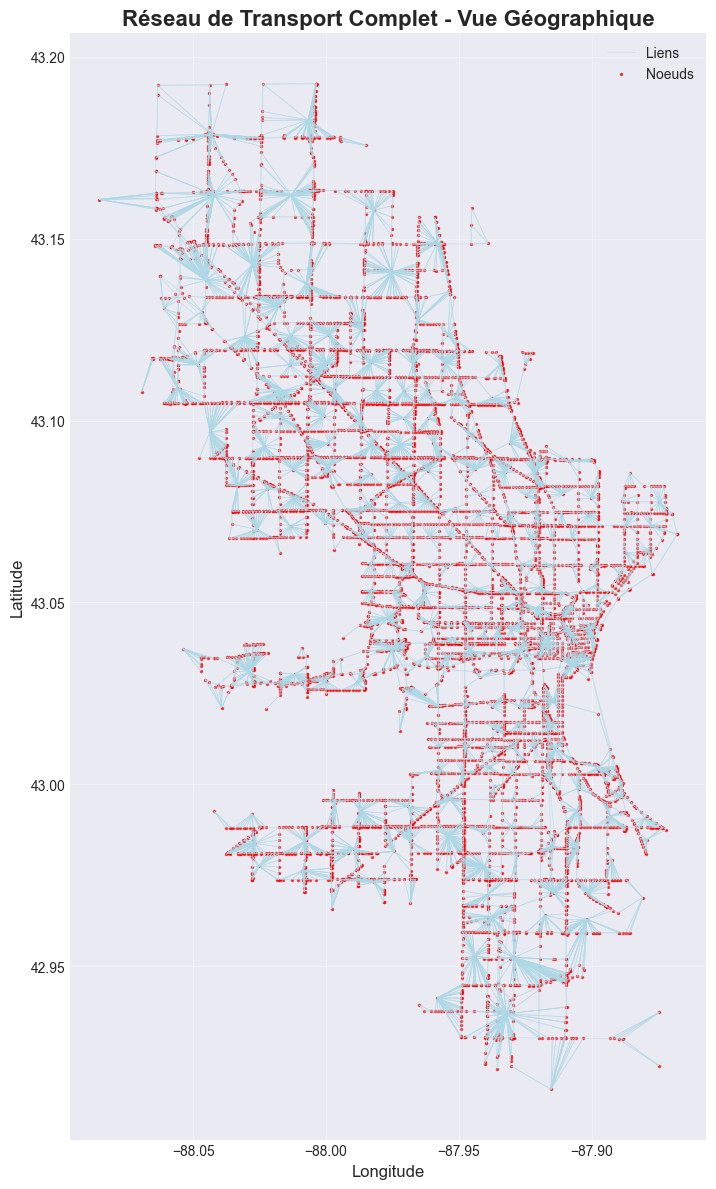

✓ Carte du réseau affichée: 8521 noeuds, 30747 liens


In [12]:
# Visualisation basique du réseau complet
fig, ax = plt.subplots(figsize=(15, 12))

# Dessiner les liens
links_gdf.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.6, label='Liens')

# Dessiner les noeuds
nodes_gdf.plot(ax=ax, color='red', markersize=2, alpha=0.7, label='Noeuds')

plt.title('Réseau de Transport Complet - Vue Géographique', fontsize=16, fontweight='bold')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✓ Carte du réseau affichée: {len(nodes_gdf)} noeuds, {len(links_gdf)} liens")

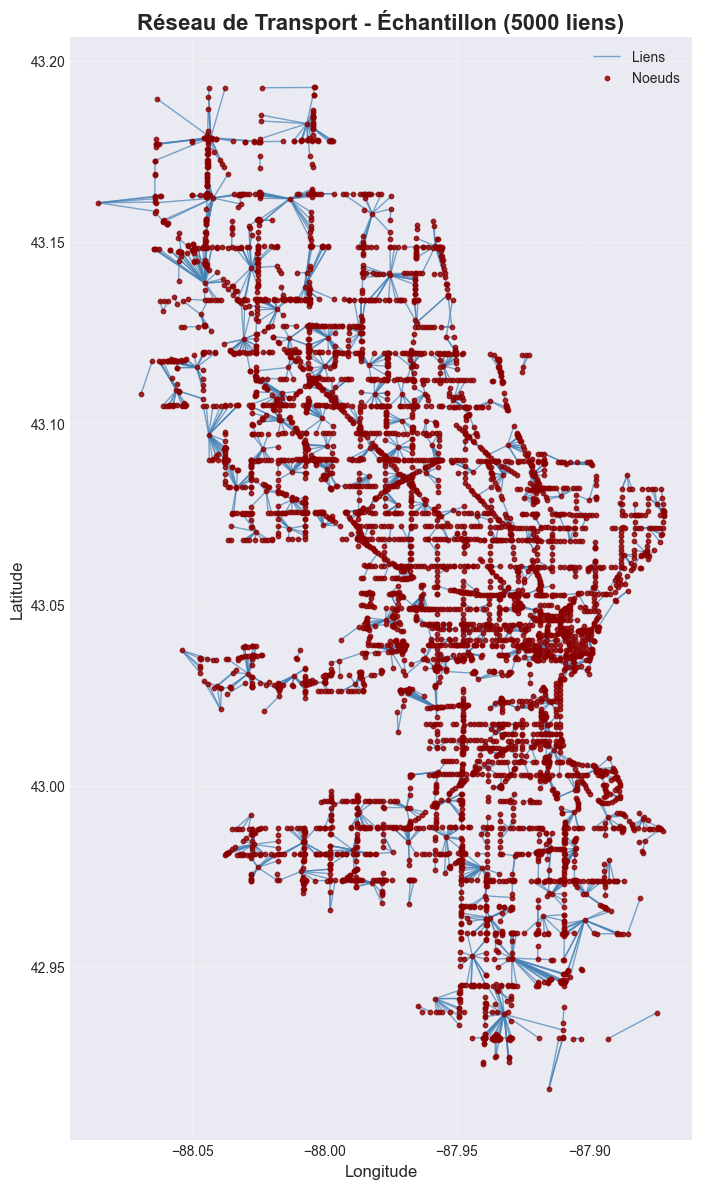

In [13]:
# Visualisation avec zoom sur un sous-ensemble
fig, ax = plt.subplots(figsize=(15, 12))

# Prendre un échantillon pour une vue plus détaillée
sample_size = min(5000, len(links_gdf))
links_sample = links_gdf.sample(n=sample_size, random_state=42)

# Obtenir les noeuds correspondants
node_ids = set(links_sample['from_node_id'].tolist() + links_sample['to_node_id'].tolist())
nodes_sample = nodes_gdf[nodes_gdf['node_id'].isin(node_ids)]

# Dessiner
links_sample.plot(ax=ax, color='steelblue', linewidth=1, alpha=0.7, label='Liens')
nodes_sample.plot(ax=ax, color='darkred', markersize=10, alpha=0.8, label='Noeuds', zorder=5)

plt.title(f'Réseau de Transport - Échantillon ({sample_size} liens)', fontsize=16, fontweight='bold')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

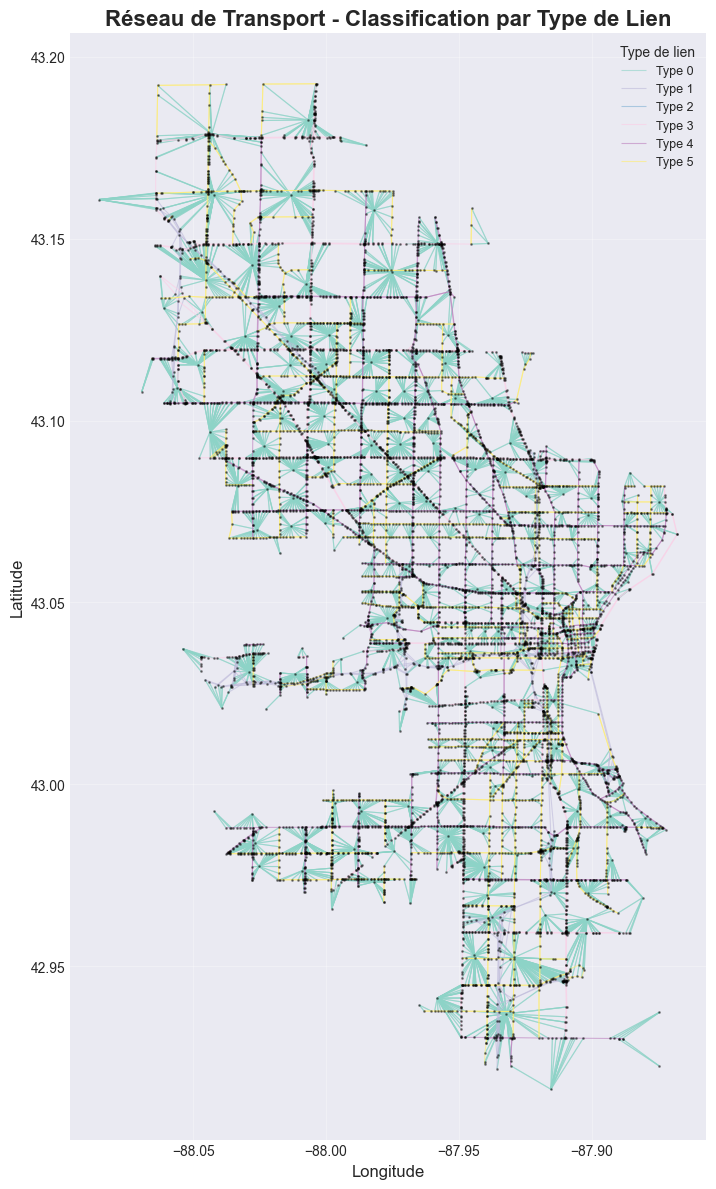

In [14]:
# Visualisation des liens par type
fig, ax = plt.subplots(figsize=(15, 12))

# Grouper les liens par type
link_types = links_gdf['link_type'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(link_types)))

for i, link_type in enumerate(sorted(link_types)):
    subset = links_gdf[links_gdf['link_type'] == link_type]
    subset.plot(ax=ax, color=colors[i], linewidth=0.8, alpha=0.6, label=f'Type {link_type}')

nodes_gdf.plot(ax=ax, color='black', markersize=1, alpha=0.4, zorder=5)

plt.title('Réseau de Transport - Classification par Type de Lien', fontsize=16, fontweight='bold')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend(title='Type de lien', fontsize=9, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

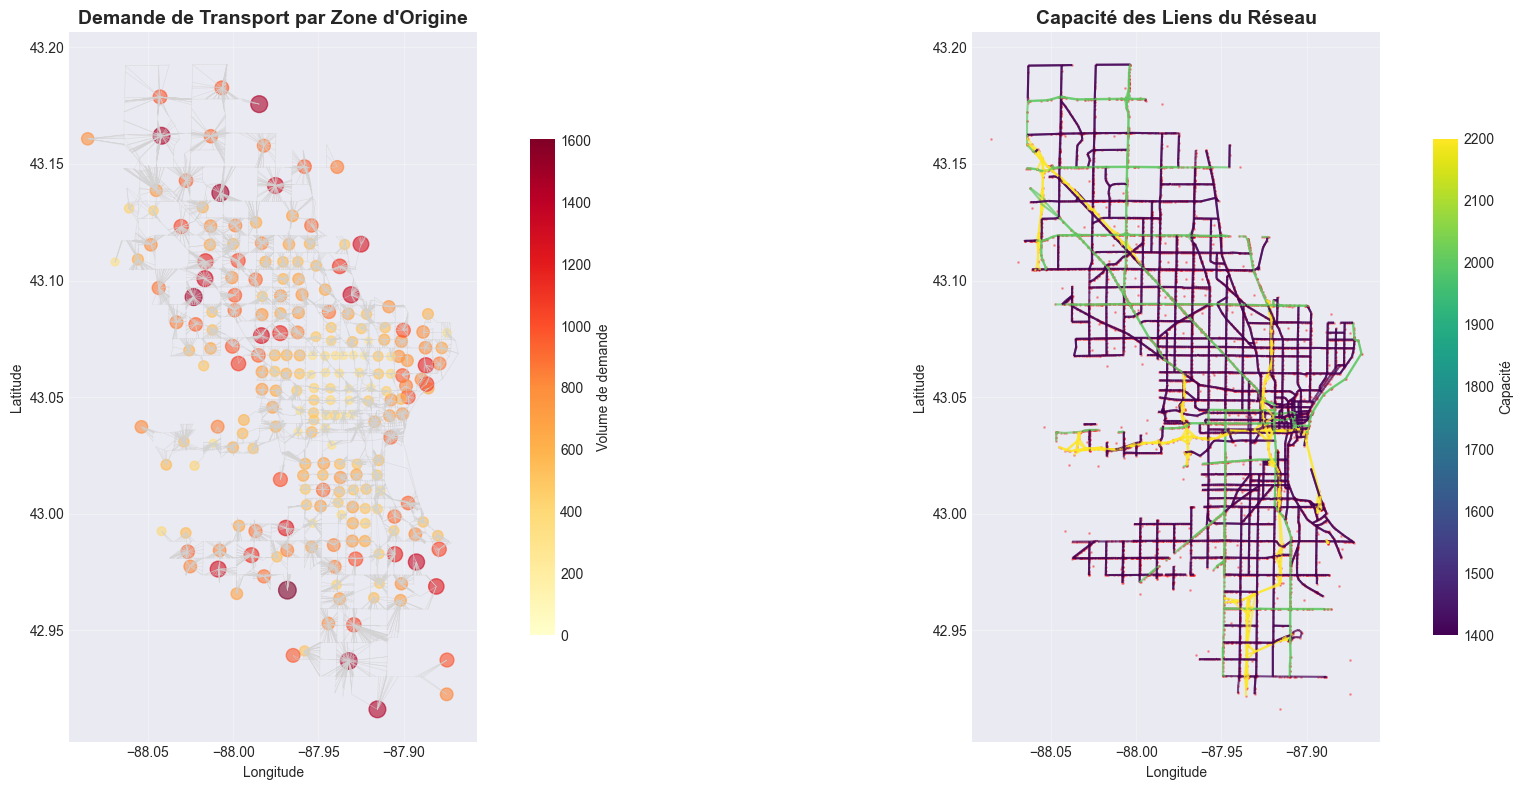

In [15]:
# Visualisation de la densité de la demande
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Agréger la demande par origine
demand_by_origin = demand_df.groupby('o_zone_id')['volume'].sum().reset_index()
demand_by_origin.columns = ['zone_id', 'total_demand']

# Fusionner avec les noeuds
nodes_with_demand = nodes_gdf.merge(demand_by_origin, on='zone_id', how='left')
nodes_with_demand['total_demand'].fillna(0, inplace=True)

# Carte 1: Demande par origine
links_gdf.plot(ax=ax1, color='lightgray', linewidth=0.3, alpha=0.5)
nodes_with_demand.plot(ax=ax1, column='total_demand', cmap='YlOrRd', 
                        markersize=nodes_with_demand['total_demand']/10,
                        alpha=0.6, legend=True, 
                        legend_kwds={'label': 'Volume de demande', 'shrink': 0.7})
ax1.set_title('Demande de Transport par Zone d\'Origine', fontsize=14, fontweight='bold')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.grid(True, alpha=0.3)

# Carte 2: Capacité des liens
links_gdf_vis = links_gdf[links_gdf['capacity'] < 99999]  # Exclure les capacités infinies
links_gdf_vis.plot(ax=ax2, column='capacity', cmap='viridis', 
                   linewidth=1.5, alpha=0.7, legend=True,
                   legend_kwds={'label': 'Capacité', 'shrink': 0.7})
nodes_gdf.plot(ax=ax2, color='red', markersize=1, alpha=0.3)
ax2.set_title('Capacité des Liens du Réseau', fontsize=14, fontweight='bold')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Visualisation de la demande par zone d'arrivée (destination)
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Agréger la demande par destination
demand_by_dest = demand_df.groupby('d_zone_id')['volume'].sum().reset_index()
demand_by_dest.columns = ['zone_id', 'total_demand']

# Fusionner avec les noeuds
nodes_with_dest_demand = nodes_gdf.merge(demand_by_dest, on='zone_id', how='left')
nodes_with_dest_demand['total_demand'].fillna(0, inplace=True)

# Carte 1: Demande totale par destination
links_gdf.plot(ax=axes[0, 0], color='lightgray', linewidth=0.3, alpha=0.5)
scatter1 = axes[0, 0].scatter(nodes_with_dest_demand.geometry_obj.x, 
                               nodes_with_dest_demand.geometry_obj.y,
                               c=nodes_with_dest_demand['total_demand'], 
                               cmap='YlOrRd', s=nodes_with_dest_demand['total_demand']/5,
                               alpha=0.6, edgecolors='black', linewidth=0.5)
cbar1 = plt.colorbar(scatter1, ax=axes[0, 0])
cbar1.set_label('Volume de demande', fontsize=10)
axes[0, 0].set_title('Demande de Transport par Zone de Destination', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Longitude')
axes[0, 0].set_ylabel('Latitude')
axes[0, 0].grid(True, alpha=0.3)

# Carte 2: Comparaison Origine vs Destination
demand_by_origin_2 = demand_df.groupby('o_zone_id')['volume'].sum().reset_index()
demand_by_origin_2.columns = ['zone_id', 'origin_demand']
nodes_comparison = nodes_gdf.merge(demand_by_origin_2, on='zone_id', how='left')
nodes_comparison = nodes_comparison.merge(demand_by_dest, on='zone_id', how='left')
nodes_comparison['origin_demand'].fillna(0, inplace=True)
nodes_comparison['total_demand'].fillna(0, inplace=True)
nodes_comparison['diff_demand'] = nodes_comparison['total_demand'] - nodes_comparison['origin_demand']

links_gdf.plot(ax=axes[0, 1], color='lightgray', linewidth=0.3, alpha=0.5)
scatter2 = axes[0, 1].scatter(nodes_comparison.geometry_obj.x, 
                               nodes_comparison.geometry_obj.y,
                               c=nodes_comparison['diff_demand'], 
                               cmap='RdBu_r', s=np.abs(nodes_comparison['diff_demand'])/5 + 10,
                               alpha=0.6, edgecolors='black', linewidth=0.5)
cbar2 = plt.colorbar(scatter2, ax=axes[0, 1])
cbar2.set_label('Différence (Destination - Origine)', fontsize=10)
axes[0, 1].set_title('Comparaison: Demande Destination vs Origine (Rouge=Attraction, Bleu=Production)', 
                     fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Longitude')
axes[0, 1].set_ylabel('Latitude')
axes[0, 1].grid(True, alpha=0.3)

# Graphique 3: Distribution de la demande par destination
top_destinations = demand_by_dest.nlargest(15, 'total_demand')
axes[1, 0].barh(range(len(top_destinations)), top_destinations['total_demand'].values, color='steelblue', alpha=0.7)
axes[1, 0].set_yticks(range(len(top_destinations)))
axes[1, 0].set_yticklabels([f"Zone {int(z)}" for z in top_destinations['zone_id'].values], fontsize=9)
axes[1, 0].set_xlabel('Volume de demande', fontsize=11)
axes[1, 0].set_title('Top 15 Zones de Destination - Demande Totale', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(top_destinations['total_demand'].values):
    axes[1, 0].text(v, i, f" {int(v)}", va='center', fontsize=9)

# Graphique 4: Comparaison Origine vs Destination pour les top 15 destinations
top_dest_zones = demand_by_dest.nlargest(15, 'total_demand')['zone_id'].values
comparison_data = pd.DataFrame({
    'zone_id': top_dest_zones,
})
comparison_data = comparison_data.merge(demand_by_origin_2.rename(columns={'origin_demand': 'Origine'}), 
                                        on='zone_id', how='left')
comparison_data = comparison_data.merge(demand_by_dest.rename(columns={'total_demand': 'Destination'}), 
                                        on='zone_id', how='left')
comparison_data.fillna(0, inplace=True)

x_pos = np.arange(len(comparison_data))
width = 0.35
axes[1, 1].bar(x_pos - width/2, comparison_data['Origine'].values, width, label='Origine', 
               color='skyblue', alpha=0.8, edgecolor='black', linewidth=0.5)
axes[1, 1].bar(x_pos + width/2, comparison_data['Destination'].values, width, label='Destination', 
               color='coral', alpha=0.8, edgecolor='black', linewidth=0.5)
axes[1, 1].set_xlabel('Zone', fontsize=11)
axes[1, 1].set_ylabel('Volume de demande', fontsize=11)
axes[1, 1].set_title('Comparaison Origine vs Destination - Top 15 Zones', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels([f"Z{int(z)}" for z in comparison_data['zone_id'].values], fontsize=8, rotation=45)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✓ Visualisations de la demande par destination affichées")

In [ ]:
# Statistiques détaillées sur la demande par zone d'arrivée
print("=" * 80)
print("STATISTIQUES DÉTAILLÉES - DEMANDE PAR ZONE DE DESTINATION")
print("=" * 80)

demand_by_origin_stats = demand_df.groupby('o_zone_id')['volume'].sum().reset_index()
demand_by_origin_stats.columns = ['zone_id', 'volume']
demand_by_dest_stats = demand_df.groupby('d_zone_id')['volume'].sum().reset_index()
demand_by_dest_stats.columns = ['zone_id', 'volume']

print(f"\nDemande agrégée par destination (top 20):")
print(demand_by_dest_stats.nlargest(20, 'volume').to_string(index=False))

print(f"\n\nStatistiques de la demande par destination:")
print(f"  - Demande totale par destination: {demand_by_dest_stats['volume'].sum():.0f}")
print(f"  - Demande moyenne par destination: {demand_by_dest_stats['volume'].mean():.2f}")
print(f"  - Demande max: {demand_by_dest_stats['volume'].max():.0f}")
print(f"  - Demande min: {demand_by_dest_stats['volume'].min():.0f}")
print(f"  - Écart-type: {demand_by_dest_stats['volume'].std():.2f}")

# Comparer avec l'origine
print(f"\n\nComparaison Origine vs Destination:")
print(f"  - Zones productrices (origine): {len(demand_by_origin_stats)}")
print(f"  - Zones attractrices (destination): {len(demand_by_dest_stats)}")

# Identifier les zones fortement attractrices
print(f"\n\nZones fortement attractrices (top 10 destinations):")
top_10_dest = demand_by_dest_stats.nlargest(10, 'volume')
for idx, row in top_10_dest.iterrows():
    pct = (row['volume'] / demand_by_dest_stats['volume'].sum()) * 100
    print(f"  Zone {int(row['zone_id'])}: {row['volume']:.0f} ({pct:.2f}%)")

## 7. Calcul des métriques du réseau

In [16]:
# Statistiques de base du réseau
print("=" * 80)
print("STATISTIQUES DU RÉSEAU")
print("=" * 80)
print(f"Nombre de noeuds: {G.number_of_nodes()}")
print(f"Nombre d'arcs: {G.number_of_edges()}")
print(f"Densité du réseau: {nx.density(G):.6f}")
print(f"Réseau connecté: {nx.is_strongly_connected(G)}")

# Nombre de composantes connectées
n_components = nx.number_strongly_connected_components(G)
print(f"Nombre de composantes fortement connectées: {n_components}")

if n_components > 1:
    components = list(nx.strongly_connected_components(G))
    sizes = [len(c) for c in components]
    print(f"  - Taille de la plus grande composante: {max(sizes)}")
    print(f"  - Taille de la plus petite composante: {min(sizes)}")

STATISTIQUES DU RÉSEAU
Nombre de noeuds: 8521
Nombre d'arcs: 30747
Densité du réseau: 0.000424
Réseau connecté: False
Nombre de composantes fortement connectées: 5
  - Taille de la plus grande composante: 8493
  - Taille de la plus petite composante: 4


In [17]:
# Calcul des degrés des noeuds
in_degree = dict(G.in_degree())
out_degree = dict(G.out_degree())
total_degree = {node: in_degree[node] + out_degree[node] for node in G.nodes()}

# Ajouter les degrés aux noeuds
nodes_gdf['in_degree'] = nodes_gdf['node_id'].map(in_degree)
nodes_gdf['out_degree'] = nodes_gdf['node_id'].map(out_degree)
nodes_gdf['total_degree'] = nodes_gdf['node_id'].map(total_degree)

print("=" * 80)
print("DISTRIBUTION DES DEGRÉS")
print("=" * 80)
print(f"Degré entrant moyen: {np.mean(list(in_degree.values())):.2f}")
print(f"Degré sortant moyen: {np.mean(list(out_degree.values())):.2f}")
print(f"Degré total moyen: {np.mean(list(total_degree.values())):.2f}")
print(f"Degré max: {max(total_degree.values())}")
print(f"Degré min: {min(total_degree.values())}")

DISTRIBUTION DES DEGRÉS
Degré entrant moyen: 3.61
Degré sortant moyen: 3.61
Degré total moyen: 7.22
Degré max: 218
Degré min: 2


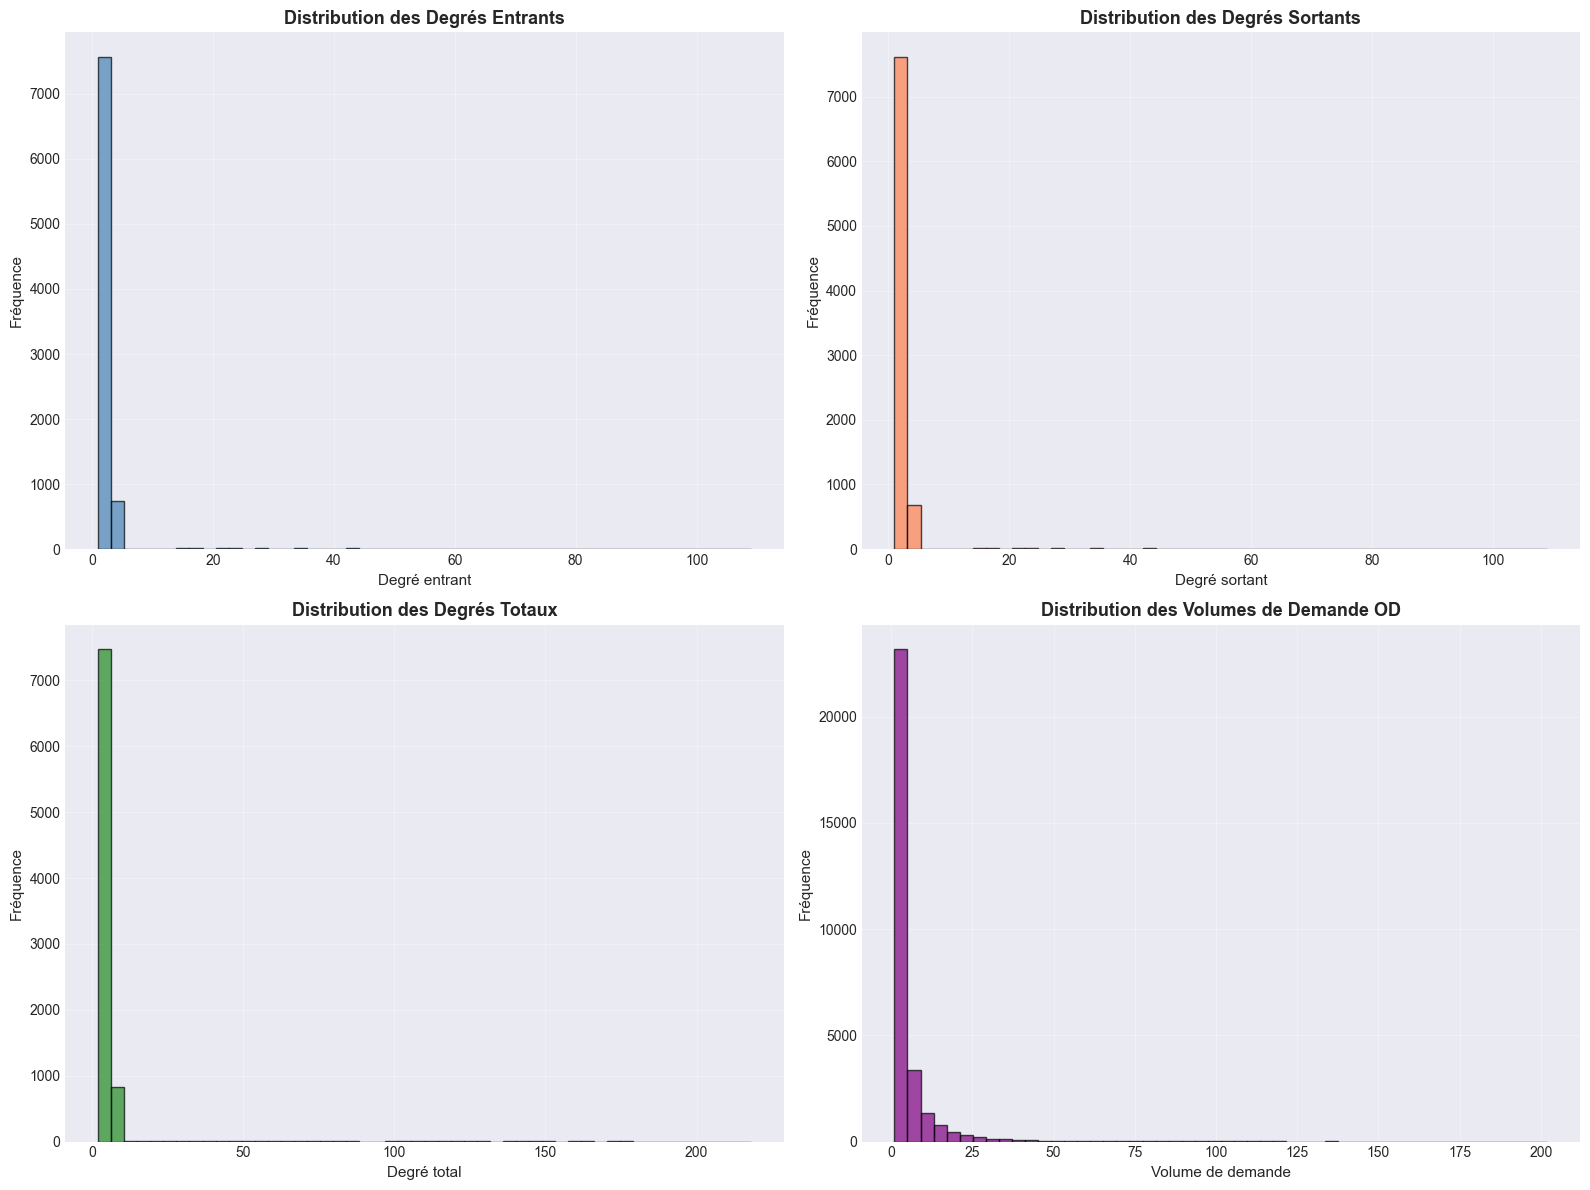

In [18]:
# Visualisation de la distribution des degrés
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Histogramme des degrés entrants
axes[0, 0].hist(list(in_degree.values()), bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Degré entrant', fontsize=11)
axes[0, 0].set_ylabel('Fréquence', fontsize=11)
axes[0, 0].set_title('Distribution des Degrés Entrants', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Histogramme des degrés sortants
axes[0, 1].hist(list(out_degree.values()), bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Degré sortant', fontsize=11)
axes[0, 1].set_ylabel('Fréquence', fontsize=11)
axes[0, 1].set_title('Distribution des Degrés Sortants', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Histogramme des degrés totaux
axes[1, 0].hist(list(total_degree.values()), bins=50, color='forestgreen', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Degré total', fontsize=11)
axes[1, 0].set_ylabel('Fréquence', fontsize=11)
axes[1, 0].set_title('Distribution des Degrés Totaux', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Distribution de la demande
axes[1, 1].hist(demand_df['volume'], bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Volume de demande', fontsize=11)
axes[1, 1].set_ylabel('Fréquence', fontsize=11)
axes[1, 1].set_title('Distribution des Volumes de Demande OD', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

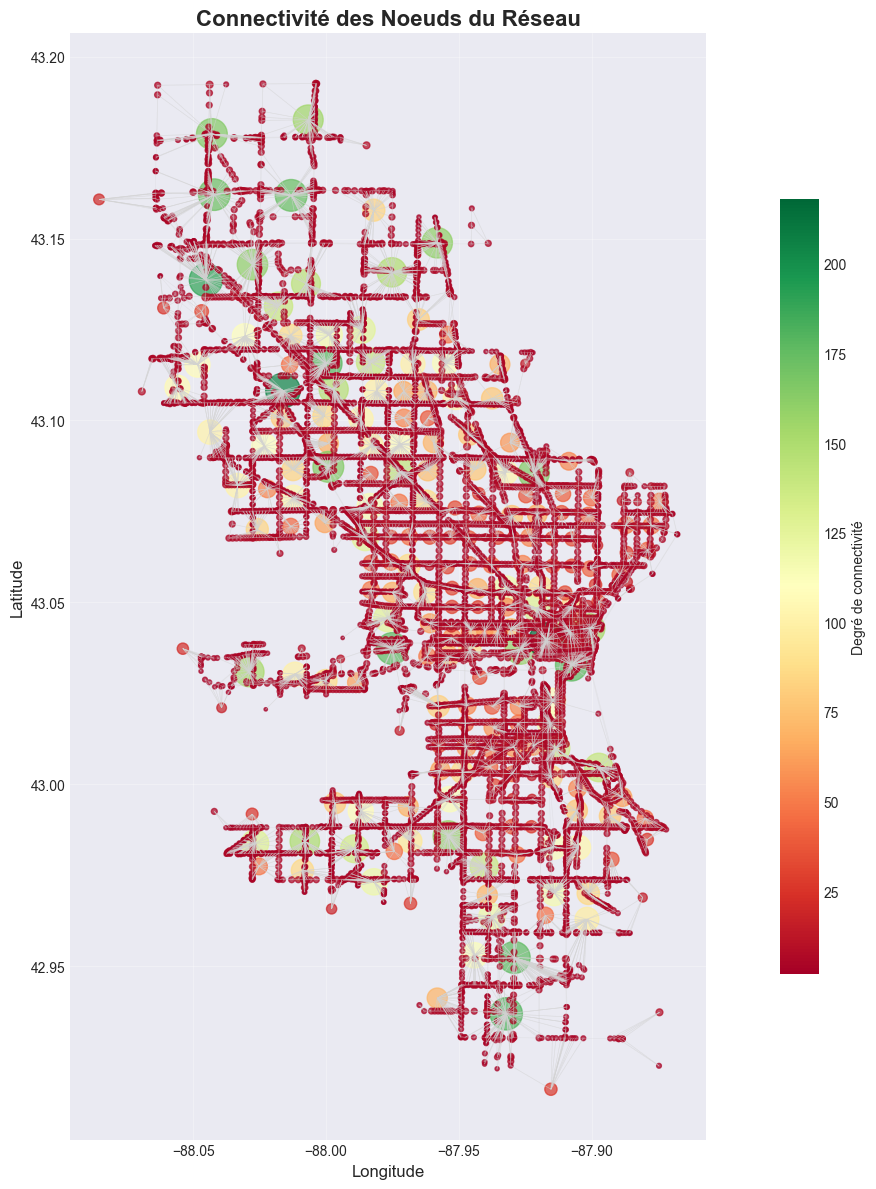


TOP 10 NOEUDS LES PLUS CONNECTÉS
 node_id  zone_id  total_degree    x_coord   y_coord
      67     67.0           218 -87.917036 43.039480
     204    204.0           206 -88.016217 43.108229
     229    229.0           190 -88.045191 43.138600
       7      7.0           180 -87.932203 42.936895
     225    225.0           178 -88.000026 43.115671
      49     49.0           176 -87.907695 43.032757
      79     79.0           176 -87.929223 42.952383
     138    138.0           176 -87.975065 43.037306
     143    143.0           174 -88.013132 43.161862
     220    220.0           172 -88.042056 43.162057


In [19]:
# Visualisation des noeuds par degré de connectivité
fig, ax = plt.subplots(figsize=(15, 12))

# Dessiner les liens
links_gdf.plot(ax=ax, color='lightgray', linewidth=0.4, alpha=0.4)

# Dessiner les noeuds colorés par degré total
nodes_gdf.plot(ax=ax, column='total_degree', cmap='RdYlGn', 
               markersize=nodes_gdf['total_degree']*3,
               alpha=0.7, legend=True,
               legend_kwds={'label': 'Degré de connectivité', 'shrink': 0.7})

plt.title('Connectivité des Noeuds du Réseau', fontsize=16, fontweight='bold')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Identifier les noeuds les plus connectés
top_nodes = nodes_gdf.nlargest(10, 'total_degree')[['node_id', 'zone_id', 'total_degree', 'x_coord', 'y_coord']]
print("\n" + "=" * 80)
print("TOP 10 NOEUDS LES PLUS CONNECTÉS")
print("=" * 80)
print(top_nodes.to_string(index=False))

In [20]:
# Calculer la centralité de degré (pour un échantillon du réseau)
print("Calcul de la centralité de degré...")

# Prendre un échantillon pour les calculs intensifs
if G.number_of_nodes() > 1000:
    print(f"⚠ Réseau volumineux ({G.number_of_nodes()} noeuds). Calcul sur la plus grande composante...")
    # Obtenir la plus grande composante fortement connectée
    largest_cc = max(nx.strongly_connected_components(G), key=len)
    G_sample = G.subgraph(largest_cc).copy()
else:
    G_sample = G

degree_centrality = nx.degree_centrality(G_sample)
in_degree_centrality = nx.in_degree_centrality(G_sample)
out_degree_centrality = nx.out_degree_centrality(G_sample)

print(f"✓ Centralité calculée pour {len(degree_centrality)} noeuds")
print(f"  - Centralité moyenne: {np.mean(list(degree_centrality.values())):.6f}")
print(f"  - Centralité max: {max(degree_centrality.values()):.6f}")
print(f"  - Centralité min: {min(degree_centrality.values()):.6f}")

Calcul de la centralité de degré...
⚠ Réseau volumineux (8521 noeuds). Calcul sur la plus grande composante...
✓ Centralité calculée pour 8493 noeuds
  - Centralité moyenne: 0.000851
  - Centralité max: 0.025671
  - Centralité min: 0.000236


In [21]:
# Statistiques des liens
print("=" * 80)
print("STATISTIQUES DES LIENS")
print("=" * 80)
print(f"\nLongueur des liens:")
print(links_gdf['length'].describe())

print(f"\nVitesse libre (free_speed):")
print(links_gdf['free_speed'].describe())

print(f"\nNombre de voies (lanes):")
print(links_gdf['lanes'].describe())

print(f"\nCapacité:")
capacity_finite = links_gdf[links_gdf['capacity'] < 99999]['capacity']
print(capacity_finite.describe())

STATISTIQUES DES LIENS

Longueur des liens:
count    30747.000000
mean        52.579838
std        107.224728
min          0.000000
25%          0.000000
50%          0.000000
75%         89.925000
max       2699.120000
Name: length, dtype: float64

Vitesse libre (free_speed):
count    30747.000000
mean        31.770742
std         19.853319
min         15.000000
25%         15.000000
50%         15.000000
75%         45.000000
max         90.000000
Name: free_speed, dtype: float64

Nombre de voies (lanes):
count    30747.000000
mean         1.141510
std          0.407728
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: lanes, dtype: float64

Capacité:
count    14173.000000
mean      1564.778099
std        281.935323
min       1400.000000
25%       1400.000000
50%       1400.000000
75%       2000.000000
max       2200.000000
Name: capacity, dtype: float64


## Résumé et Conclusions

Ce notebook a permis de:
1. ✅ Charger et convertir les données GMNS en GeoDataFrames GeoPandas
2. ✅ Créer un graphe NetworkX représentant le réseau de transport
3. ✅ Visualiser le réseau géographiquement avec différentes perspectives
4. ✅ Calculer et analyser les métriques de connectivité du réseau
5. ✅ Analyser la distribution spatiale de la demande de transport

### Résultats clés:
- Le réseau contient plusieurs milliers de noeuds et de liens
- La structure est dirigée, reflétant les sens de circulation
- Les visualisations permettent d'identifier les zones à forte demande et les noeuds critiques
- Les métriques de centralité identifient les intersections importantes du réseau